In [1]:
import io
import shutil
import requests
import pandas as pd
import numpy as np
import csv
import glob
import os
from sklearn import linear_model
import numpy
from datetime import datetime

def mask(df, key, value):
    return df[df[key] == value]

## Import of Delay Data

In [2]:
url = 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/03ec9d0a-b16f-4e78-8e4f-2da4970efbb6/download/fahrzeiten_soll_ist_20180325_20180331.csv'
s = requests.get(url).content
c = pd.read_csv(io.StringIO(s.decode('utf-8')), index_col=None)

## Time difference calculation and formatting

In [3]:
df = pd.DataFrame(data=c)
df.drop(df.columns[[3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]], axis=1, inplace=True)
pd.DataFrame.mask = mask
df = df.mask('linie',69)
check = pd.DataFrame(data=df)
col = check.shape[1]
row = check.shape[0]
print(row)
print(col)
df.loc[:,'diff'] = (df['ist_an_von'] - df['soll_an_von'])
dp = df.copy()
dp.reset_index(drop=True, inplace=True)
dp.loc[:,'time'] = dp.loc[:,'soll_an_von'].copy().astype(float)
dp.loc[:,'time'] = pd.to_datetime(dp.loc[:,'time'], errors='coerce', unit='s')
dp.loc[:,'time'] = dp.loc[:,'time'].dt.strftime('%H:%M')
df1 = dp.copy()
df1.drop(dp.columns[[3, 4]], axis=1, inplace=True)
df1['time'] = pd.to_datetime(df1['betriebsdatum'] + ' ' + df1['time'])
df1.drop(df1.columns[[2]],axis=1, inplace = True)
df1.loc[:,'diff'] = df1.loc[:,'diff'].apply(pd.to_numeric, errors='coerce',downcast='float')
df1.loc[:,'time'] = df1.loc[:,'time'].dt.round('60min') 
print(df1.head())
print(df1.dtypes)

15390
5
   linie  richtung  diff       time
0     69         2   -55 2018-03-25
1     69         2   -50 2018-03-25
2     69         2   -32 2018-03-25
3     69         2   -33 2018-03-25
4     69         2   -16 2018-03-25
linie                int64
richtung             int64
diff                 int64
time        datetime64[ns]
dtype: object


## Import of Weather Data .csv

In [4]:
#turn off warnings
pd.options.mode.chained_assignment = None
#input folder
path = r'./weather/*.csv'
#import csv as dataframe
new_cols = ['weather']
we = pd.read_csv(glob.glob('./weather/*.csv')[0], header=None, names = new_cols)
wet1 = pd.DataFrame(data = we)
#clean-up
wet = wet1.iloc[3:]
wet.loc[:,'time'] = wet.weather.str.split(';').str.get(0)
wet.loc[:,'rain'] = wet.weather.str.split(';').str.get(1) 
wet.drop(wet.columns[[0]], axis=1, inplace = True)
wet.loc[:,'time'] = pd.to_datetime(wet.loc[:,'time'])
wet.loc[:,'rain'] = wet.loc[:,'rain'].apply(pd.to_numeric, errors='coerce')

q = wet.shape[1]
o = wet.shape[0]
print('Number of columns: %d'%q)
print('Number of rows: %d'%o)   
print(wet.head())
print(wet.dtypes)

Number of columns: 2
Number of rows: 8784
                 time  rain
3 2017-03-31 00:00:00   0.0
4 2017-03-31 01:00:00   0.0
5 2017-03-31 02:00:00   0.0
6 2017-03-31 03:00:00   0.0
7 2017-03-31 04:00:00   0.0
time    datetime64[ns]
rain           float64
dtype: object


## Matching Rain and Time Difference

In [6]:
# def nearest(items, pivot):
#     return min(items, key=lambda x: abs(x - pivot))
# df1.apply(nearest(wet.loc[:,'time'],df1.loc[:,'time']))
# df1.set_index(df1.loc[:,'time'], inplace=True)
# wet.set_index(wet.loc[:,'time'], inplace=True)

# print(df1.head())
# print(wet.head())

# left merge on both time col which are in datetime format
merge = df1.merge(wet, left_on='time', right_on='time', how='left')
print(merge)
print(merge.dtypes)
# df1.iloc[df1.index.get_loc(wet.loc[:,'time'],method='nearest')]
# df1['time'] = pd.DatetimeIndex(wet['time']).normalize()
# df1.apply(lambda col: col.drop_duplicates().reset_index(drop=True))
# pred = pd.merge(df1, wet).head()


       linie  richtung  diff                time  rain
0         69         2   -55 2018-03-25 00:00:00   0.0
1         69         2   -50 2018-03-25 00:00:00   0.0
2         69         2   -32 2018-03-25 00:00:00   0.0
3         69         2   -33 2018-03-25 00:00:00   0.0
4         69         2   -16 2018-03-25 00:00:00   0.0
5         69         2    -4 2018-03-25 00:00:00   0.0
6         69         2    11 2018-03-25 00:00:00   0.0
7         69         1   -46 2018-03-25 00:00:00   0.0
8         69         1   -30 2018-03-25 00:00:00   0.0
9         69         1   -54 2018-03-25 00:00:00   0.0
10        69         1   -39 2018-03-25 00:00:00   0.0
11        69         1   -22 2018-03-25 00:00:00   0.0
12        69         1     1 2018-03-25 00:00:00   0.0
13        69         1     8 2018-03-25 00:00:00   0.0
14        69         1     9 2018-03-25 00:00:00   0.0
15        69         1   -10 2018-03-25 01:00:00   0.0
16        69         1    -4 2018-03-25 00:00:00   0.0
17        

## Prediction

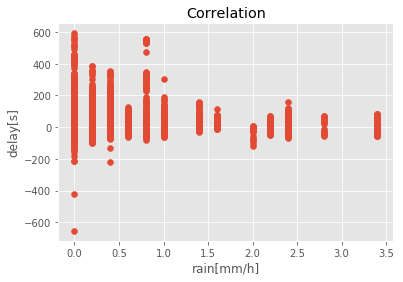

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm

x = merge.loc[:,'rain']
y = merge.loc[:,'diff']

# output folder
newpath = r'./output/'
if os.path.exists(newpath):
    shutil.rmtree(newpath, ignore_errors=True)
os.makedirs(newpath)
plt.scatter(x,y)
plt.title("Correlation")
plt.xlabel("rain[mm/h]")
plt.ylabel("delay[s]")
plt.savefig('./output/plot.png', format='png', dpi=1200)
# plt.show()

# X = np.array([[1,2],
#              [5,8],
#              [1.5,1.8],
#              [8,8],
#              [1,0.6],
#              [9,11]])

# y = [0,1,0,1,0,1]
# X.reshape(1, -1)

# clf = svm.SVC(kernel='linear', C = 1.0)
# clf.fit(X,y)

# print(clf.predict([0.58,0.76]))


# x_train = merge.loc[:,'rain']
# y_train = merge.loc[:,'diff']
# x_test = merge.loc[:,'rain']

# linear = linear_model.LinearRegression()
# linear.fit(x_train, y_train)
# linear.score(x_train, y_train)
# print('Coefficient: \n', linear.coef_)
# print('Intercept: \n', linear.intercept_)
# predicted= linear.predict(x_test)

## Output